In [24]:
from sklearn.ensemble import VotingClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import pipeline
%matplotlib inline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator


import src.utils as utils

In [46]:

#inputs is a map of format {name: input_file.csv}
def construct_dataframe(inputs):
    df_X = []
    df_y = []
    for prefix, filename in inputs.items():
        data = pd.read_pickle(filename)
        
        data_X = data.drop('y', axis=1).add_prefix(prefix + "_")
        df_X.append(data_X)
        
        data_y = data['y']
        df_y.append(data_y)
        # sanity check, all y should match
    return pd.concat(df_X, axis=1, sort=False), pd.concat(df_y, axis=1, sort=False) # TODO: y should join

def split_train_test(X,y):
    test_X = X.loc[utils.TEST_KEYS]
    train_X = X.loc[X.index.difference(utils.TEST_KEYS)]
    test_y = y.loc[utils.TEST_KEYS]
    train_y = y.loc[y.index.difference(utils.TEST_KEYS)]
    return train_X, train_y, test_X, test_y

In [79]:
input_data = {
    "cnn": "inception/data_inception_cnn_diff_reduced_dim_augmented.pkl"
}
X, y = construct_dataframe(input_data)
X, y, _,_  = split_train_test(X, y)


In [94]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, pref):
        self.pref = pref

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        filter_cols = [col for col in X if col.startswith(self.pref)]
        return X[filter_cols]

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf3 = GaussianNB()
cnn = pipeline.Pipeline([
    ('col_extract', ColumnExtractor("cnn_")),
    ('clf', clf1)
])

In [96]:
eclf = VotingClassifier(estimators=[('cnn', cnn), ('gnb', clf3)])

In [72]:
def train_ensemble(X, y, multiclass, cv=3, test_size=0.3):
    params = [{'voting':['soft', 'hard']}]
    m = GridSearchCV(eclf, cv=cv, param_grid = params)
    utils.do_CV(X,y, m, multi_class=multiclass, test_size=test_size)
    return m.best_estimator_

In [ ]:
def do_CV(X,y, model, multi_class=True, test_size=0.3):
    # Change to 2-class
    if not multi_class:
        y = y.replace('S', 'SR')
        y = y.replace('R', 'SR')
    # Split the dataset in two equal parts
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0, stratify=y)

    print("# Tuning hyper-parameter")
    print()

    model.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    if hasattr(model, "best_params_"):
        print(model.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, p in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, p))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred)
    if multi_class == False:
        my_dict = {'I':1, 'SR':-1}
        print("ROC AUC score")
        print(roc_auc_score(np.vectorize(my_dict.get)(y_test), np.vectorize(my_dict.get)(y_pred)))
        plot_roc_binary(y_test, model.predict_proba(X_test))
    else:
        plot_roc_multi(y_test, model.predict_proba(X_test))
    print()
    print("This is the classification report for the eval set:")
    print(classification_report(y_test, y_pred))

    print("This is the classification report for the training set:")
    y_train_pred = model.predict(X_train)
    print(classification_report(y_train, y_train_pred))
    return model.best_estimator_

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

params = [{'voting':['soft', 'hard']}]
m = GridSearchCV(eclf, cv=5, param_grid = params)
eclf.fit(X_train, y_train)

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('cnn', Pipeline(steps=[('col_extract', ColumnExtractor(pref='cnn_')), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False))])), ('gnb', GaussianNB(priors=None))],
         n_jobs=1, voting='hard', weights=None)

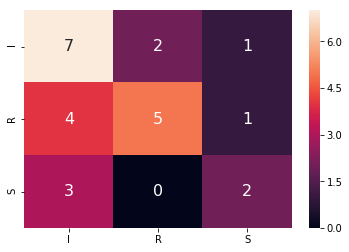

IndexError: too many indices for array

In [109]:
from sklearn.metrics import roc_auc_score
def get_vals(model, X_test, y_test, multi_class=False):
    y_pred = model.predict(X_test)
    utils.plot_confusion_matrix(y_test, y_pred)
    if multi_class == False:
        my_dict = {'I':1, 'SR':-1}
        print("ROC AUC score")
        print(roc_auc_score(np.vectorize(my_dict.get)(y_test), np.vectorize(my_dict.get)(y_pred)))
        utils.plot_roc_binary(y_test, model.predict(X_test))
    else:
        utils.plot_roc_multi(y_test, model.predict(X_test))
    print()
    print("This is the classification report for the eval set:")
    print(classification_report(y_test, y_pred))

    print("This is the classification report for the training set:")
    y_train_pred = model.predict(X_train)
    print(classification_report(y_train, y_train_pred))

get_vals(eclf,X_test, y_test, multi_class=True)

In [101]:
y_test

,y
33/8-14-12/1-29-15,I
12/4-16-13/3-13-15,S
10/6-21-17/9-22-16,I
12/5-29-12/4-16-13,I
9/6-20-18/3-23-17,R
7b/4-10-12/5-28-15,I
7b/5-28-15/4-10-12,R
1/10-05-15/10-06-14,I
10/9-22-16/6-21-17,R
10/3-7-14/9-22-16,S


In [82]:


tuned_parameters = [
  {
    'estimator__kernel': ['rbf'],
    'estimator__gamma': [1e-3, 1e-4],
    'estimator__C': [1, 10, 100, 1000]
  },
  {
    'estimator__kernel': ['linear'], 
    'estimator__C': [1, 10, 100, 1000]
  }
]

model_to_set = OneVsRestClassifier(SVC(), n_jobs=-1)
clf = GridSearchCV(model_to_set, tuned_parameters)
clf.fit(X_train, y_train)

NameError: name 'OneVsRestClassifier' is not defined

In [78]:
train_ensemble(train_X,train_y,multiclass=False, cv=None)

# Tuning hyper-parameter



IndexError: too many indices for array

In [21]:
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf3, eclf)]

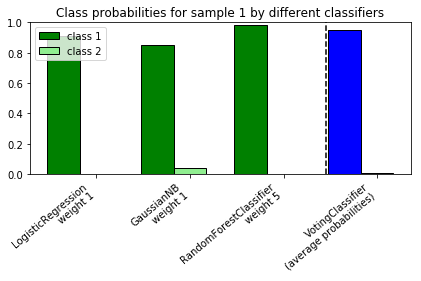

In [28]:
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]


# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['LogisticRegression\nweight 1',
                    'GaussianNB\nweight 1',
                    'RandomForestClassifier\nweight 5',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.tight_layout()
plt.show()

In [43]:

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn import pipeline



In [45]:
pipe1 = pipeline.Pipeline([
    ('col_extract', ColumnExtractor("inception.")),
    ('clf', GaussianNB())
])

In [46]:
pipe1.fit(X,y)

Pipeline(steps=[('col_extract', ColumnExtractor(cols=[40, 59, 85])), ('clf', GaussianNB(priors=None))])

In [53]:
filter(lambda x: x.startswith(2), list(X))

In [57]:
[col for col in X if col.startswith('foo')]

AttributeError: 'int' object has no attribute 'startswith'